=== 1. 生成数据 ===
Input shape: (200, 64, 1), Output shape: (200, 64, 2)

=== 2. POD per Variable 分析 (线性压缩) ===
POD Reconstruction MSE: 0.053436

=== 3. FNO 训练 (算子学习) ===
Start Training FNO...
Epoch 0: Loss = 0.345228
Epoch 50: Loss = 0.133859
Epoch 100: Loss = 0.086030
Epoch 150: Loss = 0.039208
Epoch 200: Loss = 0.043352
Epoch 250: Loss = 0.068666
Epoch 300: Loss = 0.055739
Epoch 350: Loss = 0.085781
Epoch 400: Loss = 0.096002
Epoch 450: Loss = 0.048441

=== 4. 结果可视化 ===


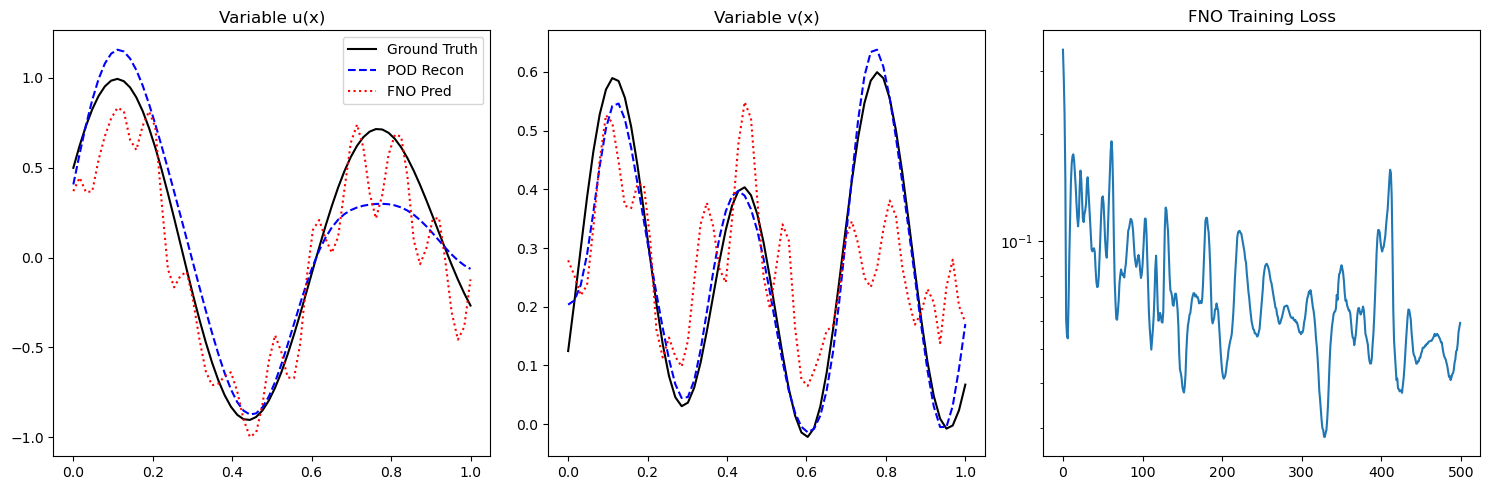

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import numpy as np

# 设置精度
jax.config.update("jax_enable_x64", True)

# ==========================================
# 1. 数据生成器 (模拟物理场)
# ==========================================
def generate_1d_data(n_samples=100, n_points=64, key=None):
    """
    生成模拟数据：两个耦合的物理量 u(x) 和 v(x)
    输入 a(x) 控制频率和相位
    """
    if key is None: key = jr.PRNGKey(0)
    
    x = jnp.linspace(0, 1, n_points)
    
    # 生成随机系数
    keys = jr.split(key, n_samples)
    
    def get_sample(k):
        # 随机参数
        freq = jr.uniform(k, (), minval=1.0, maxval=4.0)
        phase = jr.uniform(k, (), minval=0.0, maxval=jnp.pi)
        
        # Input function a(x)
        a = jnp.sin(2 * jnp.pi * freq * x + phase)
        
        # Output solution u(x) and v(x) (模拟某种物理关系)
        # u 是平滑的波
        u = a * jnp.cos(x) 
        # v 是高频一点的波，且幅度不同（体现多变量特性）
        v = 0.5 * a**2 + 0.1 * jnp.sin(10 * x)
        
        # Stack channels: (n_points, 2)
        # channel 0: u, channel 1: v
        return a[..., None], jnp.stack([u, v], axis=-1)

    inputs, outputs = jax.vmap(get_sample)(keys)
    return x, inputs, outputs

# ==========================================
# 2. POD per Variable (分变量降阶)
# ==========================================
class PODModel:
    def __init__(self, n_modes):
        self.n_modes = n_modes
        self.mean = None
        self.basis = None # (n_points, n_modes)

    def fit(self, data):
        # data shape: (n_samples, n_points)
        self.mean = jnp.mean(data, axis=0)
        data_centered = data - self.mean
        
        # SVD: X = U S V^T
        # U 的列就是我们要的基向量 (POD modes)
        # data_centered.T shape: (n_points, n_samples)
        U, S, Vt = jnp.linalg.svd(data_centered.T, full_matrices=False)
        self.basis = U[:, :self.n_modes]

    def project(self, data):
        # 编码: High Dim -> Low Dim
        return (data - self.mean) @ self.basis

    def reconstruct(self, coeffs):
        # 解码: Low Dim -> High Dim
        return coeffs @ self.basis.T + self.mean

class MultiVariablePOD:
    """
    对每个变量分别做 POD
    """
    def __init__(self, n_modes_list):
        self.pods = [PODModel(m) for m in n_modes_list]
    
    def fit(self, data):
        # data shape: (n_samples, n_points, n_vars)
        n_vars = data.shape[-1]
        for i in range(n_vars):
            self.pods[i].fit(data[..., i])
            
    def reconstruct(self, data):
        # 演示用：先投影再重建，看压缩效果
        recons = []
        n_vars = data.shape[-1]
        for i in range(n_vars):
            coeffs = self.pods[i].project(data[..., i])
            rec = self.pods[i].reconstruct(coeffs)
            recons.append(rec)
        return jnp.stack(recons, axis=-1)

# ==========================================
# 3. 1D FNO (Fourier Neural Operator)
# ==========================================
class SpectralConv1d(eqx.Module):
    weights: jnp.ndarray
    in_channels: int
    out_channels: int
    modes: int

    def __init__(self, in_channels, out_channels, modes, key):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        
        # 初始化复数权重
        k1, k2 = jr.split(key)
        scale = 1 / (in_channels * out_channels)
        self.weights = (
            jr.uniform(k1, (in_channels, out_channels, modes)) * scale +
            1j * jr.uniform(k2, (in_channels, out_channels, modes)) * scale
        )

    def __call__(self, x):
        # x shape: (in_channels, n_points) -> 注意这里为了FFT方便，通常在空间维度做变换
        # 输入进来之前我们会转置一下
        
        # 1. FFT
        x_ft = jnp.fft.rfft(x, axis=-1)
        
        # 2. 频域乘法 (只取前 modes 个低频)
        # e.g., output[k] = sum_i weights[i, o, k] * input[i, k]
        out_ft = jnp.zeros((self.out_channels, x_ft.shape[-1]), dtype=jnp.complex128)
        
        # 使用 einsum 进行批量乘法
        # i: in_channels, o: out_channels, k: modes
        mul = jnp.einsum("iok,ik->ok", self.weights, x_ft[:, :self.modes])
        
        # 将乘法结果放入低频部分
        out_ft = out_ft.at[:, :self.modes].set(mul)
        
        # 3. Inverse FFT
        x = jnp.fft.irfft(out_ft, n=x.shape[-1], axis=-1)
        return x

class FNO1d(eqx.Module):
    lift: eqx.nn.Linear
    layers: list
    proj: eqx.nn.MLP

    def __init__(self, in_dim, out_dim, width, modes, depth, key):
        keys = jr.split(key, depth + 2)
        
        # 提升维度 P: (in) -> (width)
        self.lift = eqx.nn.Linear(in_dim, width, key=keys[0])
        
        self.layers = []
        for i in range(depth):
            k_spec, k_conv = jr.split(keys[i+1])
            self.layers.append([
                SpectralConv1d(width, width, modes, k_spec),
                # 这里的 Conv1d 充当公式中的 W (局部线性变换)
                eqx.nn.Conv1d(width, width, kernel_size=1, key=k_conv) 
            ])
            
        # 投影 Q: (width) -> (out)
        self.proj = eqx.nn.MLP(width, out_dim, width*2, depth=1, key=keys[-1])

    def __call__(self, x):
        # x shape: (n_points, in_dim)
        
        # Lifting: apply pointwise
        x = jax.vmap(self.lift)(x) 
        
        # Permute to (channels, n_points) for Conv/FFT layers
        x = jnp.transpose(x, (1, 0)) 

        for spec_layer, conv_layer in self.layers:
            x_spec = spec_layer(x)
            x_conv = conv_layer(x)
            x = jax.nn.gelu(x_spec + x_conv)

        # Permute back to (n_points, channels)
        x = jnp.transpose(x, (1, 0))
        
        # Projection: apply pointwise
        x = jax.vmap(self.proj)(x)
        return x

# ==========================================
# 4. Training Loop (训练循环)
# ==========================================
def loss_fn(model, x, y):
    # x: input (batch, grid, in_dim)
    # y: target (batch, grid, out_dim)
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)

@eqx.filter_jit
def train_step(model, opt_state, optimizer, x, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# ==========================================
# 5. Main Execution (主程序)
# ==========================================
def main():
    print("=== 1. 生成数据 ===")
    key = jr.PRNGKey(42)
    x_grid, inputs, outputs = generate_1d_data(n_samples=200, n_points=64, key=key)
    
    # inputs: (200, 64, 1) -> 函数 a(x)
    # outputs: (200, 64, 2) -> 解 u(x), v(x)
    print(f"Input shape: {inputs.shape}, Output shape: {outputs.shape}")

    # 划分训练/测试集
    train_x, test_x = inputs[:150], inputs[150:]
    train_y, test_y = outputs[:150], outputs[150:]

    print("\n=== 2. POD per Variable 分析 (线性压缩) ===")
    # 比如我们想看用多少个模态能重建 u 和 v
    # u 比较简单用 4 个模态，v 比较复杂用 8 个模态
    pod_system = MultiVariablePOD(n_modes_list=[4, 8]) 
    pod_system.fit(train_y)
    
    # 验证 POD 重建效果
    y_pod_recon = pod_system.reconstruct(test_y)
    pod_error = jnp.mean((test_y - y_pod_recon)**2)
    print(f"POD Reconstruction MSE: {pod_error:.6f}")

    print("\n=== 3. FNO 训练 (算子学习) ===")
    # 定义模型：输入1维(a)，输出2维(u, v)
    model = FNO1d(
        in_dim=1, 
        out_dim=2, 
        width=32, 
        modes=12,  # 保留低频模式数
        depth=3, 
        key=jr.PRNGKey(0)
    )
    
    # 优化器
    optimizer = optax.adam(learning_rate=1e-3)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    
    # 训练循环
    epochs = 500
    batch_size = 32
    n_train = len(train_x)
    
    print("Start Training FNO...")
    loss_history = []
    
    for epoch in range(epochs):
        # 简单的 Batching
        perm = jr.permutation(jr.PRNGKey(epoch), n_train)
        epoch_loss = 0
        
        for i in range(0, n_train, batch_size):
            idx = perm[i:i+batch_size]
            batch_x, batch_y = train_x[idx], train_y[idx]
            
            model, opt_state, loss = train_step(model, opt_state, optimizer, batch_x, batch_y)
            epoch_loss += loss
            
        avg_loss = epoch_loss / (n_train // batch_size)
        loss_history.append(avg_loss)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {avg_loss:.6f}")

    print("\n=== 4. 结果可视化 ===")
    # 预测
    test_pred = jax.vmap(model)(test_x)
    
    # 绘图：对比真实解、POD重建解、FNO预测解
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    sample_idx = 0
    # 画变量 u (channel 0)
    ax[0].plot(x_grid, test_y[sample_idx, :, 0], 'k-', label='Ground Truth')
    ax[0].plot(x_grid, y_pod_recon[sample_idx, :, 0], 'b--', label='POD Recon')
    ax[0].plot(x_grid, test_pred[sample_idx, :, 0], 'r:', label='FNO Pred')
    ax[0].set_title("Variable u(x)")
    ax[0].legend()
    
    # 画变量 v (channel 1)
    ax[1].plot(x_grid, test_y[sample_idx, :, 1], 'k-', label='Ground Truth')
    ax[1].plot(x_grid, y_pod_recon[sample_idx, :, 1], 'b--', label='POD Recon')
    ax[1].plot(x_grid, test_pred[sample_idx, :, 1], 'r:', label='FNO Pred')
    ax[1].set_title("Variable v(x)")
    
    # 画 Loss
    ax[2].semilogy(loss_history)
    ax[2].set_title("FNO Training Loss")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()